In [1]:
from __future__ import annotations

import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from ase.io import read
from mpi4py import MPI
from qtpyt.basis import Basis

from qtpyt.base.selfenergy import DataSelfEnergy as BaseDataSelfEnergy
from qtpyt.projector import expand


comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


In [2]:
from matplotlib.colors import LinearSegmentedColormap


maroon_cmap = LinearSegmentedColormap.from_list(
    "white_to_maroon",
    ["white", "#800000"],
    N=256
)

In [3]:
class DataSelfEnergy(BaseDataSelfEnergy):
    """Wrapper"""

    def retarded(self, energy):
        return expand(S_molecule_identity, super().retarded(energy), idx_molecule)


def load(filename):
    return DataSelfEnergy(energies, np.load(filename))


def compute_gamma_from_sigma(sigma: np.ndarray) -> np.ndarray:
    """
    Compute the broadening matrix Γ from a retarded self-energy Σ.

    Parameters
    ----------
    sigma : np.ndarray
        Retarded self-energy matrix Σ^r(ω) (square, complex), shape (N, N).

    Returns
    -------
    np.ndarray
        Broadening matrix Γ(ω), shape (N, N), complex.

    Notes
    -----
    The broadening is defined as

        Γ(ω) = i [Σ^r(ω) - Σ^a(ω)].

    With the advanced self-energy given by Σ^a = (Σ^r)†, this becomes

        Γ(ω) = i [Σ^r(ω) - (Σ^r(ω))†].

    In code, this is implemented as

        Γ = 1j * (sigma - sigma.conj().T).

    Γ is Hermitian when Σ is a proper retarded self-energy (numerically it may have
    tiny non-Hermitian components; the expression above enforces Hermitian structure
    up to floating-point error).
    """
    return 1j * (sigma - sigma.conj().T)


def compute_transmission(
    sigma_L: np.ndarray, sigma_R: np.ndarray, G_r: np.ndarray
) -> float:
    """
    Compute the Landauer transmission T(E) from projected self-energies and the retarded Green's function.

    Parameters
    ----------
    sigma_L : np.ndarray
        Left retarded self-energy on the molecular subspace Σ_L^r(E), shape (N_mol, N_mol).
    sigma_R : np.ndarray
        Right retarded self-energy on the molecular subspace Σ_R^r(E), shape (N_mol, N_mol).
    G_r : np.ndarray
        Retarded Green's function on the molecular subspace G^r(E), shape (N_mol, N_mol).

    Returns
    -------
    float
        Transmission T(E) (real scalar). Any small imaginary part produced by finite numerical
        precision is discarded via `np.real(...)`.

    Notes
    -----
    The transmission is computed as

        T(E) = Tr[ Γ_L(E) G^r(E) Γ_R(E) G^a(E) ],

    where

        Γ_{L/R}(E) = i [Σ_{L/R}^r(E) - Σ_{L/R}^a(E)]
                   = i [Σ_{L/R}^r(E) - (Σ_{L/R}^r(E))†],

    and

        G^a(E) = (G^r(E))†.

    Matrix operations:
    - Compute Γ_L and Γ_R from Σ_L and Σ_R
    - Form G^a as the conjugate transpose of G^r
    - Multiply in the order Γ_L @ G^r @ Γ_R @ G^a
    - Take the trace and keep the real part
    """
    G_a = G_r.conj().T
    gamma_L = compute_gamma_from_sigma(sigma_L)
    gamma_R = compute_gamma_from_sigma(sigma_R)
    return float(np.real(np.trace(gamma_L @ G_r @ gamma_R @ G_a)))


def combine_HS_leads_tip_blocks(hs_list_ii, hs_list_ij, side: str):
    """
    Merge selected lead and tip Hamiltonian/overlap blocks into a single (lead+tip) block
    and build the corresponding coupling block to the molecular region.

    Parameters
    ----------
    hs_list_ii : list
        List of on-site (diagonal) blocks [(H_i, S_i), ...]. Each H_i, S_i is a square matrix.
        This function assumes a specific indexing convention:
        - left uses indices 0 (bulk) and 1 (tip)
        - molecule is index 2 (not merged here)
        - right uses indices 3 (tip) and 4 (bulk)
    hs_list_ij : list
        List of off-diagonal coupling blocks [(H_ij, S_ij), ...] consistent with hs_list_ii.
        This function assumes a specific indexing convention:
        - left lead<->tip coupling is hs_list_ij[0]
        - left (tip -> mol) coupling is hs_list_ij[1]
        - (mol -> right tip) coupling is hs_list_ij[2]
        - right tip<->bulk coupling is hs_list_ij[3]
    side : str
        Which side to build. Must be "left" or "right".

    Returns
    -------
    tuple[list, list]
        (hs_ii_merge, hs_ij_merge)

        hs_ii_merge : list
            A one-element list [(H_merge, S_merge)] containing the merged (lead+tip) on-site
            block, shape (N_full, N_full).
        hs_ij_merge : list
            A one-element list containing the coupling between the merged (lead+tip) space and
            the molecular space. The orientation depends on `side`:

            - side == "left": returns [(H_lm_merge, S_lm_merge)] with shape (N_full, N_mol),
              i.e. (lead+tip -> mol)
            - side == "right": returns [(H_mr_merge, S_mr_merge)] with shape (N_mol, N_full),
              i.e. (mol -> lead+tip)

    Notes
    -----
    Block assembly (generic):
        H_merge = [ H_A      H_coup     ]
                  [ H_coup†  H_B        ]

        S_merge = [ S_A      S_coup     ]
                  [ S_coup†  S_B        ]

    where A/B are the chosen sub-blocks (bulk and tip, ordered depending on side) and † denotes
    conjugate transpose.

    Left side bookkeeping used here:
    - Order is [bulk, tip] in the merged space.
    - The coupling returned is (lead+tip -> mol), built by vertically padding zeros to align the
      molecule coupling with the tip part of the merged space:

        H_lm_merge = [ 0_(N_bulk, N_mol) ]
                     [ H_tip,mol        ]

      (same for S).

    Right side bookkeeping used here:
    - Order is [tip, bulk] in the merged space.
    - The coupling returned is (mol -> lead+tip), built by horizontally padding zeros to align
      the coupling with the tip part of the merged space:

        H_mr_merge = [ H_mol,tip   0_(N_mol, N_bulk) ]

      (same for S).

    This asymmetry in orientation is intentional and matches how `compute_projected_self_energy`
    branches on `direction` (left expects H_lm; right expects H_ml).
    """
    if side == "left":
        H_bulk, S_bulk = hs_list_ii[0]
        H_tip, S_tip = hs_list_ii[1]
        H_coup, S_coup = hs_list_ij[0]

        H_merge = np.block([[H_bulk, H_coup], [H_coup.T.conj(), H_tip]])
        S_merge = np.block([[S_bulk, S_coup], [S_coup.T.conj(), S_tip]])

        H_lm, S_lm = hs_list_ij[1]

        n_bulk = H_bulk.shape[0]
        n_mol = H_lm.shape[1]

        H_lm_merge = np.vstack([np.zeros((n_bulk, n_mol)), H_lm])
        S_lm_merge = np.vstack([np.zeros((n_bulk, n_mol)), S_lm])
        return [(H_merge, S_merge)], [(H_lm_merge, S_lm_merge)]

    if side == "right":
        H_tip, S_tip = hs_list_ii[3]
        H_bulk, S_bulk = hs_list_ii[4]
        H_coup, S_coup = hs_list_ij[3]

        H_merge = np.block([[H_tip, H_coup], [H_coup.T.conj(), H_bulk]])
        S_merge = np.block([[S_tip, S_coup], [S_coup.T.conj(), S_bulk]])

        H_mr, S_mr = hs_list_ij[2]
        n_bulk = H_bulk.shape[0]
        n_mol = H_mr.shape[0]
        H_mr_merge = np.hstack([H_mr, np.zeros((n_mol, n_bulk))])
        S_mr_merge = np.hstack([S_mr, np.zeros((n_mol, n_bulk))])

        return [(H_merge, S_merge)], [(H_mr_merge, S_mr_merge)]

    raise ValueError("side must be 'left' or 'right'")


def pad_self_energy_to_full_space(
    sigma_lead: np.ndarray, n_full: int, direction: str
) -> np.ndarray:
    """
    Embed a lead self-energy Σ_lead into a larger (lead+tip) "full" space by zero-padding.

    Parameters
    ----------
    sigma_lead : np.ndarray
        Lead self-energy matrix Σ_lead (retarded), shape (N_lead, N_lead).
        This is typically the output of `PrincipalSelfEnergy.retarded(E)`.
    n_full : int
        Dimension of the target full space (lead+tip), N_full.
        Must satisfy N_full >= N_lead.
    direction : str
        Where to place Σ_lead in the N_full × N_full matrix. Must be "left" or "right".

    Returns
    -------
    np.ndarray
        Padded self-energy Σ_full, shape (N_full, N_full), where Σ_lead occupies the
        top-left ("left") or bottom-right ("right") block and all other entries are zero.

    Notes
    -----
    This function builds

        Σ_full = 0_(N_full, N_full)

    and then inserts Σ_lead into a corner block.

    If direction == 'left':
        Σ_full = [ Σ_lead     0      ]
                 [   0     0_pad    ]

    If direction == 'right':
        Σ_full = [ 0_pad     0       ]
                 [   0     Σ_lead   ]

    where 0_pad denotes a zero block of the appropriate size.

    Matrix operations:
    - allocate zeros((N_full, N_full))
    - copy Σ_lead into [:N_lead, :N_lead] for 'left'
      or into [-N_lead:, -N_lead:] for 'right'
    """
    n_lead = sigma_lead.shape[0]
    sigma_padded = np.zeros((n_full, n_full), dtype=sigma_lead.dtype)
    if direction == "left":
        sigma_padded[:n_lead, :n_lead] = sigma_lead
    elif direction == "right":
        sigma_padded[-n_lead:, -n_lead:] = sigma_lead
    else:
        raise ValueError("direction must be 'left' or 'right'")
    return sigma_padded


def compute_projected_self_energy(
    hs_list_ii: list,
    hs_list_ij: list,
    sigma_lead: np.ndarray,
    energy: float,
    eta: complex,
    direction: str,
) -> np.ndarray:
    """
    Compute the self-energy projected onto the molecular subspace via explicit elimination
    of the (lead+tip) degrees of freedom.

    Parameters
    ----------
    hs_list_ii : list
        List containing the (lead+tip) on-site block as a one-element list [(H_l, S_l)].
        - For direction == "left": this is taken from hs_list_ii[0]
        - For direction == "right": this is taken from hs_list_ii[-1]
        H_l and S_l have shape (N_full, N_full).
    hs_list_ij : list
        List containing the coupling between lead+tip and molecule as a one-element list.
        Expected orientation depends on `direction` (as used by this function):

        - direction == "left": hs_list_ij[0] = (H_lm, S_lm) with shape (N_full, N_mol)
                               (lead+tip -> mol)
        - direction == "right": hs_list_ij[-1] = (H_ml, S_ml) with shape (N_mol, N_full)
                                (mol -> lead+tip)

    sigma_lead : np.ndarray
        Self-energy on the lead+tip full space, Σ_full(E), shape (N_full, N_full).
        Typically built by padding a pure lead self-energy into the full space.
    energy : float
        Energy E (in eV, consistent with the Hamiltonian units).
    eta : complex
        Small positive broadening parameter η used to form z = E + iη.
        This should be a real positive number in practice, but the type is complex to match
        the call sites.
    direction : str
        Which branch to use. Must be "left" or "right".

    Returns
    -------
    np.ndarray
        Projected self-energy Σ̃(E) acting on the molecular subspace, shape (N_mol, N_mol).

    Notes
    -----
    Reference
        Eqn. 7 of http://dx.doi.org/10.1063/1.4897448

    Definitions
    ----------
    Let z = E + iη.

    The projected self-energy onto the molecular subspace is computed as

        Σ̃(E) = (z S_ml - H_ml) [ z S_l - H_l - Σ_full(E) ]^{-1} (z S_lm - H_lm).

    Here:
    - (H_l, S_l) are the lead+tip on-site blocks (full space), shape (N_full, N_full)
    - (H_lm, S_lm) couple full space -> molecule, shape (N_full, N_mol)
    - (H_ml, S_ml) couple molecule -> full space, shape (N_mol, N_full)
    - Σ_full(E) is the full-space self-energy (padded), shape (N_full, N_full)

    Direction-dependent bookkeeping
    -------------------------------
    If direction == "left":
        H_l,  S_l  = hs_list_ii[0]
        H_lm, S_lm = hs_list_ij[0]              (N_full, N_mol)
        H_ml, S_ml = (H_lm)†, (S_lm)†           (N_mol, N_full)

        Then:
            A = z S_ml - H_ml                   (N_mol, N_full)
            C = z S_lm - H_lm                   (N_full, N_mol)
            M = z S_l  - H_l  - Σ_full          (N_full, N_full)

    If direction == "right":
        H_l,  S_l  = hs_list_ii[-1]
        H_ml, S_ml = hs_list_ij[-1]             (N_mol, N_full)
        H_lm, S_lm = (H_ml)†, (S_ml)†           (N_full, N_mol)

        Then A, C, M are formed in the same way.

    Matrix operations performed
    ---------------------------
    1) Form A, C, M as above
    2) Solve M X = C  for X  (i.e. X = M^{-1} C)
    3) Return Σ̃ = A @ X

    This avoids explicitly forming M^{-1}.
    """
    z = energy + eta * 1j

    if direction == "left":
        H_l, S_l = hs_list_ii[0]
        H_lm, S_lm = hs_list_ij[0]
        H_ml = H_lm.T.conj()
        S_ml = S_lm.T.conj()
        H_lm_use, S_lm_use = H_lm, S_lm

    elif direction == "right":
        H_l, S_l = hs_list_ii[-1]
        H_ml, S_ml = hs_list_ij[-1]
        H_lm_use = H_ml.T.conj()
        S_lm_use = S_ml.T.conj()

    else:
        raise ValueError("direction must be 'left' or 'right'")

    A = z * S_ml - H_ml  # (N_mol, N_full)
    C = z * S_lm_use - H_lm_use  # (N_full, N_mol)
    M = z * S_l - H_l - sigma_lead  # (N_full, N_full)

    X = np.linalg.solve(M, C)  # (N_full, N_mol)
    return A @ X  # (N_mol, N_mol)


def compute_greens_function_mol(
    H_mol: np.ndarray,
    S_mol: np.ndarray,
    sigma_L: np.ndarray,
    sigma_R: np.ndarray,
    sigma_corr: np.ndarray,
    energy: float,
    eta: complex,
) -> np.ndarray:
    """
    Compute the molecular retarded Green's function G_mol(E) including coupling to left/right leads.

    Parameters
    ----------
    H_mol : np.ndarray
        Molecular Hamiltonian block H (complex), shape (N_mol, N_mol).
    S_mol : np.ndarray
        Molecular overlap block S (complex), shape (N_mol, N_mol).
    sigma_L : np.ndarray
        Projected left self-energy Σ_L(E) on the molecular subspace, shape (N_mol, N_mol).
    sigma_R : np.ndarray
        Projected right self-energy Σ_R(E) on the molecular subspace, shape (N_mol, N_mol).
    sigma_corr : np.ndarray
        corr self-energy Σ_corr(E) on the molecular subspace, shape (N_mol, N_mol).
    energy : float
        Energy E at which to evaluate the Green's function.
    eta : complex
        Broadening parameter η used to form z = E + iη.

    Returns
    -------
    np.ndarray
        Retarded Green's function G^r(E) on the molecular subspace, shape (N_mol, N_mol).

    Notes
    -----
    Reference
        Eqn. 6 of http://dx.doi.org/10.1063/1.4897448

    Definitions
    ----------
    Let z = E + iη.

    The retarded Green's function is

        G_mol(E) = [ z S_mol - H_mol - Σ_L(E) - Σ_R(E) - Σ_corr(E)]^{-1}.

    Matrix operations performed
    ---------------------------
    1) Form M = z S_mol - H_mol - Σ_L - Σ_R - Σ_corr
    2) Solve M G = I for G using `np.linalg.solve` (avoids explicit inversion)

    This returns the full inverse of M.
    """
    z = energy + eta * 1j
    M = z * S_mol - H_mol - sigma_L - sigma_R - sigma_corr
    I = np.eye(M.shape[0], dtype=M.dtype)
    return np.linalg.solve(M, I)


In [4]:
GPWDEVICEDIR = "./dft/device"
GPWLEADSDIR = "./dft/leads/"
cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)

data_folder = "./output/lowdin"
ed_data_folder = "./output/lowdin/ed"


H_leads_lcao, S_leads_lcao = np.load(pl_path / "hs_pl_k.npy")

basis_dict = {"Au": 9, "H": 5, "C": 13, "N": 13}
leads_atoms = read(pl_path / "leads.xyz")
leads_basis = Basis.from_dictionary(leads_atoms, basis_dict)
device_atoms = read(cc_path / "scatt.xyz")
device_basis = Basis.from_dictionary(device_atoms, basis_dict)

Nr = (1, 5, 3)
unit_cell_rep_in_leads = (5, 5, 3)


E_ref, T_dft_ref = np.load(f"{data_folder}/dft/ET.npy")

with open(f"{data_folder}/hs_list_ii.pkl", "rb") as f:
    hs_list_ii = pickle.load(f)
with open(f"{data_folder}/hs_list_ij.pkl", "rb") as f:
    hs_list_ij = pickle.load(f)


de = 0.01
E_sampler = np.arange(-3, -2.99 + de / 2.0, de).round(7)
energies = np.arange(-3, 3 + de / 2.0, de).round(7)
nE = len(E_sampler)

In [5]:
leads_self_energy = np.load(f"{data_folder}/self_energy.npy", allow_pickle=True)
se_left = leads_self_energy[0]
se_right = leads_self_energy[1]
ed_self_energy = np.load(
    f"{ed_data_folder}/self_energy_with_dcc.npy", allow_pickle=True
)
ed_self_energy_file = f"{ed_data_folder}/self_energy_with_dcc.npy"
nodes = np.load(f"{data_folder}/nodes.npy")
index_active_region = np.load(f"{data_folder}/index_active_region.npy")
imb = 2  # index of molecule block from the nodes list
S_molecule = hs_list_ii[imb][1]  # overlap of molecule
S_molecule_identity = np.eye(S_molecule.shape[0])
idx_molecule = (
    index_active_region - nodes[imb]
)  # indices of active region w.r.t molecule

hs_ii_left, hs_ij_left = combine_HS_leads_tip_blocks(hs_list_ii, hs_list_ij, "left")
hs_ii_right, hs_ij_right = combine_HS_leads_tip_blocks(hs_list_ii, hs_list_ij, "right")

H_mol, S_mol = hs_list_ii[2]


In [6]:
ed_self_energy.shape
eta = 1e-2


In [7]:
nodes = np.load(f"{data_folder}/nodes.npy")
index_active_region = np.load(f"{data_folder}/index_active_region.npy")
imb = 2  # index of molecule block from the nodes list
S_molecule = hs_list_ii[imb][1]  # overlap of molecule
S_molecule_identity = np.eye(S_molecule.shape[0])
idx_molecule = (
    index_active_region - nodes[imb]
)  #
energy = 0.0
ed_sigma = load(ed_self_energy_file)


In [8]:
sigma_L_lead = se_left.retarded(energy)
sigma_R_lead = se_right.retarded(energy)
sigma_corr = ed_sigma.retarded(energy)

print("Shape of sigma_L_lead:", sigma_L_lead.shape)
print("Shape of sigma_R_lead:", sigma_R_lead.shape)
print("Shape of sigma_corr:", sigma_corr.shape)

Shape of sigma_L_lead: (810, 810)
Shape of sigma_R_lead: (810, 810)
Shape of sigma_corr: (162, 162)


In [9]:
sigma_L_pad = pad_self_energy_to_full_space(
    sigma_L_lead,
    n_full=hs_ii_left[0][0].shape[0],
    direction="left",
)
sigma_R_pad = pad_self_energy_to_full_space(
    sigma_R_lead,
    n_full=hs_ii_right[0][0].shape[0],
    direction="right",
)

sigma_L_proj = compute_projected_self_energy(
    hs_list_ii=hs_ii_left,
    hs_list_ij=hs_ij_left,
    sigma_lead=sigma_L_pad,
    energy=energy,
    eta=eta,
    direction="left",
)
sigma_R_proj = compute_projected_self_energy(
    hs_list_ii=hs_ii_right,
    hs_list_ij=hs_ij_right,
    sigma_lead=sigma_R_pad,
    energy=energy,
    eta=eta,
    direction="right",
)

print("Shape of sigma_L_pad:", sigma_L_pad.shape)
print("Shape of sigma_R_pad:", sigma_R_pad.shape)
print("Shape of sigma_L_proj:", sigma_L_proj.shape)
print("Shape of sigma_R_proj:", sigma_R_proj.shape)

Shape of sigma_L_pad: (1116, 1116)
Shape of sigma_R_pad: (1116, 1116)
Shape of sigma_L_proj: (162, 162)
Shape of sigma_R_proj: (162, 162)


In [10]:
gamma_L = compute_gamma_from_sigma(sigma_L_proj)
gamma_R = compute_gamma_from_sigma(sigma_R_proj)
gamma_corr = compute_gamma_from_sigma(sigma_corr)
n_mol = H_mol.shape[0]
identity = np.eye(n_mol)
lambda_corr_inv = gamma_L + gamma_R + 2 * eta * identity
lambda_corr = np.linalg.solve(lambda_corr_inv, gamma_corr)
lambda_corr_brazilian = gamma_corr


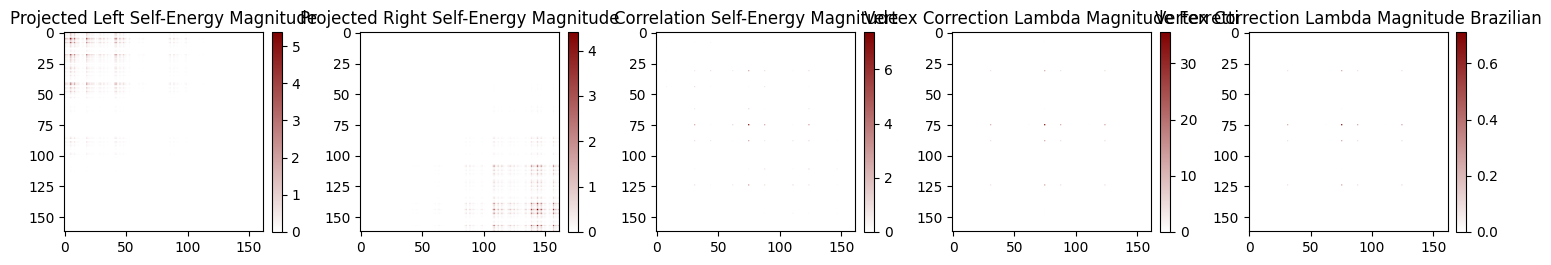

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

im0 = axes[0].imshow(np.abs(sigma_L_proj), cmap=maroon_cmap)
axes[0].set_title("Projected Left Self-Energy Magnitude")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(np.abs(sigma_R_proj), cmap=maroon_cmap)
axes[1].set_title("Projected Right Self-Energy Magnitude")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(np.abs(sigma_corr), cmap=maroon_cmap)
axes[2].set_title("Correlation Self-Energy Magnitude")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

im3 = axes[3].imshow(np.abs(lambda_corr), cmap=maroon_cmap)
axes[3].set_title("Vertex Correction Lambda Magnitude Ferretti")
plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)

im4 = axes[4].imshow(np.abs(lambda_corr_brazilian), cmap=maroon_cmap)
axes[4].set_title("Vertex Correction Lambda Magnitude Brazilian")
plt.colorbar(im4, ax=axes[4], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [12]:
G_mol = compute_greens_function_mol(
    H_mol=H_mol,
    S_mol=S_mol,
    sigma_L=sigma_L_proj,
    sigma_R=sigma_R_proj,
    sigma_corr=sigma_corr,
    energy=energy,
    eta=eta,
)

In [13]:
np.trace(lambda_corr)

(48.962025224339925+2.562959777256491e-27j)

In [14]:
G_r = G_mol
G_a = G_r.conj().T
T_elastic = float(np.real(np.trace(gamma_L @ G_r @ gamma_R @ G_a)))
T_inelatic = float(np.real(np.trace(gamma_L @ G_r @ gamma_R @ lambda_corr @ G_a)))

print(T_elastic, T_inelatic)

0.0014706467030834245 2.545761039445561e-07
